In [73]:
#@title Installing needed dependencies!
from IPython.display import clear_output
try:
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib as mplt
    import pandas as pd
    import numpy as np
    import os
    import sys
    import string
    import re
    import nltk
    from nltk import ngrams
    from unidecode import unidecode
    from nltk.corpus import stopwords
    nltk.download('stopwords')

    print("Modules required are already installed!")
except ModuleNotFoundError:
    %pip install networkx
    clear_output()
    %pip install matplotlib
    clear_output()
    %pip install pandas
    clear_output()
    %pip install nltk
    clear_output()
    %pip install unidecode
    clear_output()

    print("All modules required were sucessfully installed!")


import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mplt
import pandas as pd
import numpy as np
import os
import sys
import string
import re
import nltk
from nltk import ngrams
from unidecode import unidecode
from nltk.corpus import stopwords
nltk.download('stopwords')
clear_output()

['SoloLearn', 'Sololearn', 'Nice', 'Python', 'Java', 'sololearn', 'HTML', 'C', 'Android', 'JavaScript', 'Duolingo', 'SQL', 'C ++', 'God', 'CSS', 'Gud', 'SOLOLEARN', 'English', 'Solo Learn', 'Google', 'YouTube', 'PHP', 'Kotlin', 'Javascript', 'Ruby', 'JS', 'soloLearn', 'Facebook', 'Osm', 'Solo', 'Lua', 'Nyc', 'R', 'Ca', 'Solo learn', 'Code Playground', 'google', 'Arabic', 'Play Store', 'Html', 'nyc', 'Swift', 'C #', 'duolingo', 'Mimo', 'Codecademy', 'JAVA', 'Noice', 'Google play', 'Awsm', 'Internet', 'Linux', 'HTML5', 'Python 3', 'SL', 'Indonesian', 'Dart', 'jQuery', 'Unity', 'CS', 'India', 'LUA', 'French', 'SOLO', 'NYC', 'LinkedIn', 'Perl', 'persian', 'indonesian', 'Udemy', 'Rust', 'Persian', 'solo learn', 'Google Play', 'Iran', 'Arduino', 'MySQL', 'Go', 'Spanish', 'Instagram', 'Bootstrap', 'MATLAB', 'Django', 'Playground', 'Programming Hero', 'Amezing', 'Russian', 'Web', 'SoloLearn.', 'Python3', 'Scala', 'React', 'iran', 'CSE', 'Playstore', 'Golang', 'GOD', 'english', 'CSS3', 'google 

<ipython-input-84-3499b628f070>:259: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


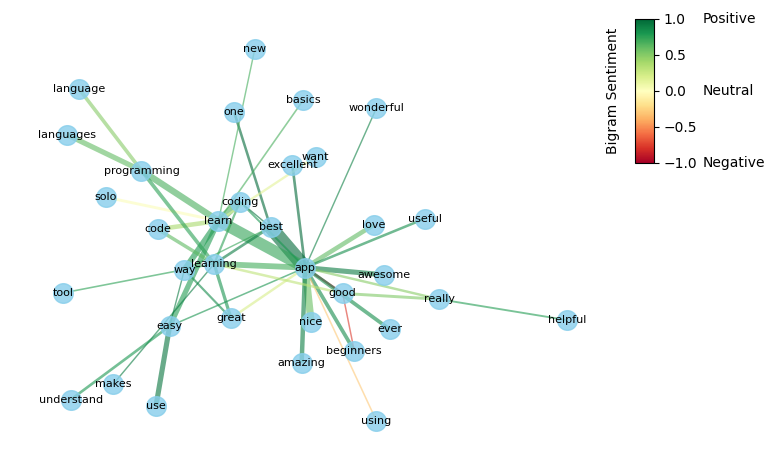

List of tuples saved as English_Google Play Store_sololearn.csv successfully.


In [84]:
from nltk.tag.brill import Word
from unidecode import unidecode
from nltk.corpus import stopwords
#@title Plot Top K Most Frequent Bigrams in Reviews by App

#@markdown **Data**

#@markdown * ### Pick language:
language = "English" #@param ["English", "Spanish"]

#@markdown * ### Pick store (There are only Google Play Store reviews for Spanish):
store = "Google Play Store" #@param ["App Store", "Google Play Store", "Combined"]

#@markdown * ### Pick app:
app = "sololearn" #@param ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "python-x", "sololearn"]


#@markdown * ### Only NER tags?
only_ner = "No" #@param ["Yes", "No"]

#@markdown * ### How many bigrams?
bigram_count = 50 #@param {type:"number"}

#@markdown * ### Add any words to exclude as a comma separated list
exclude_words = "" #@param {type:"string"}
exclude_list = [word.strip() for word in exclude_words.split(',')]


#@markdown **Graph Appearance**

#@markdown * ### Scale edge widths with bigram frequency?
edge_width_change = 'Yes' #@param ["Yes", "No"]

#@markdown * ### Scale edge colors with bigram sentiment?
edge_color_change = 'Yes' #@param ["Yes", "No"]

#@markdown * ### Layout:
graph_layout = 'Fruchterman-Reingold' #@param ["Fruchterman-Reingold", "Spring"]

#@markdown * ### Optimal distance between nodes (if nodes are too clumped up, try increasing this):
node_distance = 4 #@param {type:"number"}


dir = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/bigram-network/"
#dir = "./"

if language == 'English':

  # Reviews from different stores are named differently and in different folders
  if store == "App Store":
    dir += "applestore-review-files-standardized/"
    reviewfile = "applestore-review-" + app + "_sentiment_standardized.csv"
  elif store == 'Google Play Store':
    dir += "googleplay-review-files-standardized/"
    reviewfile = "googleplay-review-" + app + "_sentiment_standardized.csv"
  elif store == 'Combined':
    dir += "combined-review-files-standardized/"
    reviewfile = "combined-review-" + app + "_sentiment_standardized.csv"

elif language == 'Spanish':

  #   # Reviews from different stores are named differently and in different folders
  # if store == "App Store":
  #   dir += "applestore-review-files-standardized_Spanish/"
  #   reviewfile = "applestore-review-" + app + "_Spanish_sentiment_standardized.csv"
  # else:
  dir += "googleplay-review-files-standardized_Spanish/"
  reviewfile = "googleplay-review-" + app + "_Spanish_sentiment_standardized.csv"

df = pd.read_csv(dir + reviewfile)
#df = pd.read_csv('/applestore-review-codeacademy_sentiment_standardized.csv')

if language == 'English':
  dir_ner = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/NER-count/NER-count-files/"
  if store == 'App Store':
    reviewfile_ner = "applestore-review-" + app + "_NER_count.csv"
  elif store == 'Google Play Store':
    reviewfile_ner = "googleplay-review-" + app + "_NER_count.csv"

elif language == 'Spanish':
  dir_ner = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/NER-count/NER-count-files-Spanish/"
  reviewfile_ner = app + "_Spanish_NER_count.csv"

df_ner = pd.read_csv(dir_ner + reviewfile_ner)


ner_list = df_ner['NER_Text'].tolist()
print(ner_list)
# ner_set = set(ner_list)
# ner_list = [''.join(preprocess(word)) for word in ner_list]

def preprocess(text):
    # Tokenization
    text = text.split()

    # Remove leading/trailing whitespace
    text = [word.strip() for word in text]

    # Convert to lowercase
    text = [word.lower() for word in text]

    # Remove punctuation
    text = [re.sub(r'[^\w\s]', '', word) for word in text]
    #text = re.sub(r'[^\w\s]', '', word)
    
    # Remove diacritics and accents
    text = [unidecode(word) for word in text]

    
    # Remove stopwords
    
    stop_words = set(stopwords.words(language.lower()))
    text = [word for word in text if word not in stop_words]

    # Return the standardized string
    #return ' '.join(text)

    return text
    

def ner_filter(text):
    # Create a regular expression pattern to match the substrings in order of appearance
    pattern = r"\b(?:{})\b".format("|".join(map(re.escape, ner_list)))

    # Find all matching substrings in the target string while preserving order
    matching_parts = re.findall(pattern, text)

    # Combine the matching parts into a single string
    result = " ".join(matching_parts)
    #print("{}" + text + " ][ " + result + "{}\n\n")
    return result

# Removing stopwords and tokenizing
df = df.rename(columns={"content": "review", "score": "rating", "at": "date"})
df['review'] = df['review'].astype('str')
df['standardizedReview'] = df['standardizedReview'].astype('str')

if only_ner == 'No':
  df['standardizedReview'] = df['standardizedReview'].apply(preprocess) 
elif only_ner == 'Yes':
  df['review_ner'] = df['review'].apply(ner_filter)
  df['standardizedReview'] = df['review_ner'].apply(preprocess) 

if language == 'English':
  # Assigning numerical value to sentiment
  df['sentimentScore'] = df['sentiment'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}) 
elif language == 'Spanish':
  df['sentimentScore'] = df['sentiment'].map({'POS': 1, 'NEU': 0, 'NEG': -1}) 


# Generate bigrams for each review
df['bigrams'] = df['standardizedReview'].apply(lambda x: list(ngrams(x, 2)))
bigram_frequency = df['bigrams'].explode().value_counts().to_dict()

# Exclude the words provided
bigram_frequency = {bigram: frequency for bigram, frequency in bigram_frequency.items()
                    if all(word not in bigram for word in exclude_list)}

#print(df_ner['NER_Text'])

# ner_list = df_ner['NER_Text'].tolist()
# ner_list = [''.join(preprocess(word)) for word in ner_list]
# print(ner_list)

# ner_set = set(ner_list)
# print(ner_set)

# # Select the bigrams that match the NER tags
# bigram_frequency = {bigram: frequency for bigram, frequency in bigram_frequency.items()
#                     if all(word in bigram for word in ner_list)}

# print(bigram_frequency)

# Get the top k bigrams
sorted_bigrams = sorted(bigram_frequency.items(), key=lambda x: x[1], reverse=True)
filtered_bigrams = dict(sorted_bigrams[:bigram_count])

bigram_sentiment = df.explode('bigrams').groupby('bigrams')['sentimentScore'].mean().to_dict()



# Create a network graph
G = nx.Graph()

# Add nodes for unigrams and bigrams
# for unigram in df['standardizedReview'].explode().unique():
#     G.add_node(unigram)

# for bigram in filtered_bigrams:
#     G.add_node(bigram)

# Add edges with size and color attributes
for bigram, frequency in filtered_bigrams.items():
    sentiment = bigram_sentiment.get(bigram, 0.0)
    G.add_edge(bigram[0], bigram[1], weight=frequency, sentiment=sentiment)

# Set edge sizes based on frequency and edge colors based on sentiment
edge_sizes = [data['weight'] for _, _, data in G.edges(data=True)]
# min_size = min(edge_sizes)
# edge_sizes = [size - min_size for size in edge_sizes]
# edge_sizes = [size/10 for size in edge_sizes]
edge_colors = [data['sentiment'] for _, _, data in G.edges(data=True)]

# Normalize edge sizes for more regular edge widths when plotting
min_val = np.min(edge_sizes)
max_val = np.max(edge_sizes)

# Define the target range
target_min = 1
target_max = 10

# Perform min-max scaling on each list
edge_sizes = [(target_max - target_min) * (lst - min_val) / (max_val - min_val) + target_min for lst in edge_sizes]

# Position nodes using a layout algorithm (e.g., spring layout)
if graph_layout == 'Fruchterman-Reingold':
  pos = nx.spring_layout(G, k=node_distance)
elif graph_layout == 'Spring':
  pos = nx.fruchterman_reingold_layout(G, k=node_distance)

# Draw nodes, edges, labels, and adjust visual parameters
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.8)

if edge_color_change == 'Yes':

  if edge_width_change == 'Yes':
    nx.draw_networkx_edges(G, pos, width=edge_sizes, edge_color=edge_colors, edge_cmap=plt.cm.RdYlGn, alpha=0.6)
  else:
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.RdYlGn, alpha=0.6)

else:

  if edge_width_change == 'Yes':
    nx.draw_networkx_edges(G, pos, width=edge_sizes, edge_color='grey', edge_cmap=plt.cm.RdYlGn, alpha=0.6)
  else:
    nx.draw_networkx_edges(G, pos, edge_color='grey', edge_cmap=plt.cm.RdYlGn, alpha=0.6)

nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
plt.axis('off')

if edge_color_change == 'Yes':

  # Create colorbar legend
  sm = plt.cm.ScalarMappable(cmap=mplt.colormaps['RdYlGn'], norm=plt.Normalize(vmin=-1, vmax=1))
  sm.set_array([])
  cbar_ax = plt.gcf().add_axes([1, 0.65, 0.03, 0.3])  # Adjust the position and size of the colorbar axes
  cbar = plt.colorbar(sm, cax=cbar_ax, shrink=0.5)  # Assign the colorbar axes

  # Rotate the colorbar label
  cbar.ax.yaxis.set_label_coords(-1.5, 3)
  cbar.ax.set_ylabel('Bigram Sentiment')

  # Add labels next to colorbar
  plt.text(3.5, 1, 'Positive', ha='left', va='center')
  plt.text(3.5, 0, 'Neutral', ha='left', va='center')
  plt.text(3.5, -1, 'Negative', ha='left', va='center')

# Display the visualization
plt.tight_layout()
plt.show()




###Save the data into csv file for further analysis

import csv

sub=sorted_bigrams

for index in range(len(sub)):
    modified_tuple=list(sub[index])
    sentiment = bigram_sentiment.get(modified_tuple[0], 0.0)
    modified_tuple.append(sentiment)
    modified_tuple = tuple(modified_tuple)
    sub[index] = modified_tuple

output_file=language+"_"+store+ "_"+app+".csv"
# Open the CSV file in write mode
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write each tuple as a separate row
    writer.writerows(sub)

print(f"List of tuples saved as {output_file} successfully.")


['codecademy', 'oagina web edta', 'play', 'datacamp', 'diez', 'github studio', 'phyton', 'python data science toolkit', 'python r', 'rollingonthefloorlaughing', 'spark sql', 'sql server', 'udemy', 'grasshopper', 'duolingo', 'grinningfacewithbigeyes', 'sololearn', 'phyton', 'buenardo', 'smilingfacewithsmilingeyes', 'pensiveface', 'cuba', 'redheart', 'beamingfacewithsmilingeyes', 'unity', 'play store', 'udemy', 'smilingfacewithhalo', 'smilingfacewithhearteyes', 'chévere', 'smilingfacewithsunglasses', 'duo lingo', 'mexico', 'hello world', 'java script', 'facewithsteamfromnose', 'failed', 'heartsuit', 'grasshopper', 'pvta', 'grasshoper', 'vienna austria', 'okhand  okhand', 'okhand', 'latam', 'colombia', 'okhandmediumskintone', 'premio', 'mimo es la mamada', 'mimo pro', 'mimo python', 'mimo sparkles', 'play stor', 'play estore', 'mimomimo', 'play', 'minecraf', 'mundo', 'monobehaveour', 'msje hazte pro', 'mysql', 'piero', 'nasa', 'phytom sololearn', 'okhand  okhand  okhand', 'perú', 'okhandl

<ipython-input-3-8212890c19be>:315: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


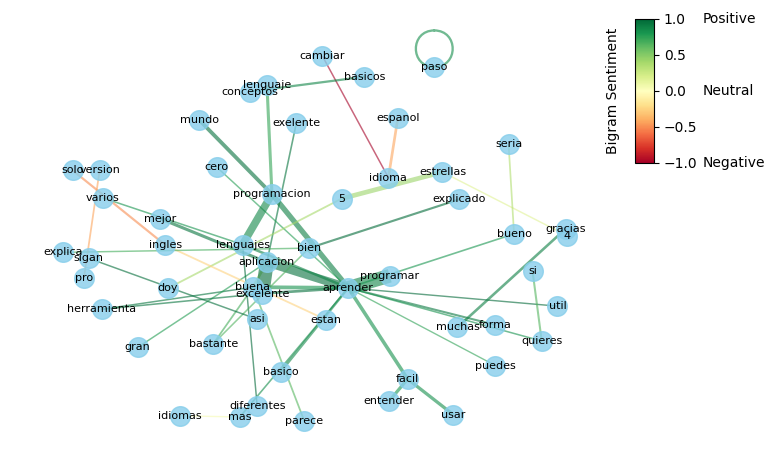

In [ ]:
from nltk.tag.brill import Word
from unidecode import unidecode
from nltk.corpus import stopwords
#@title Plot Top K Most Frequent Bigrams in All Reviews

#@markdown **Data**

#@markdown * ### Pick language:
language = "Spanish" #@param ["English", "Spanish"]

#@markdown * ### Pick store (There are only Google Play Store reviews for Spanish):
store = "Combined" #@param ["App Store", "Google Play Store", "Combined"]

#@markdown * ### Only NER tags?
only_ner = "No" #@param ["Yes", "No"]

#@markdown * ### How many bigrams?
bigram_count = 50 #@param {type:"number"}

#@markdown * ### Add any words to exclude as a comma separated list
exclude_words = "app" #@param {type:"string"}
exclude_list = [word.strip() for word in exclude_words.split(',')]


#@markdown **Graph Appearance**

#@markdown * ### Scale edge widths with bigram frequency?
edge_width_change = 'Yes' #@param ["Yes", "No"]

#@markdown * ### Scale edge colors with bigram sentiment?
edge_color_change = 'Yes' #@param ["Yes", "No"]

#@markdown * ### Layout:
graph_layout = 'Fruchterman-Reingold' #@param ["Fruchterman-Reingold", "Spring"]

#@markdown * ### Optimal distance between nodes (if nodes are too clumped up, try increasing this):
node_distance = 4 #@param {type:"number"}


dir = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/bigram-network/"
#dir = "./"

# Combining reviews of all the apps
df = pd.DataFrame(columns = ['review', 'rating', 'title', 'sentiment', 'standardizedReview'])

if language == 'English':

  # Reviews from different stores are named differently and in different folders
  if store == "App Store":

    apps = ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "python-x", "sololearn"]
    dir += "applestore-review-files-standardized/"
    
    for app in apps:
      reviewfile = "applestore-review-" + app + "_sentiment_standardized.csv"
      appdf = pd.read_csv(dir + reviewfile)
      df = pd.concat([df, appdf], ignore_index=True)

  elif store == 'Google Play Store':
    apps = ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "sololearn"]
    dir += "googleplay-review-files-standardized/"

    for app in apps:
      reviewfile = "googleplay-review-" + app + "_sentiment_standardized.csv"
      appdf = pd.read_csv(dir + reviewfile)
      df = pd.concat([df, appdf], ignore_index=True)
    
  elif store == 'Combined':
    apps = ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "sololearn"]
    dir += "combined-review-files-standardized/"

    for app in apps:
      reviewfile = "combined-review-" + app + "_sentiment_standardized.csv"
      print(dir + reviewfile)
      appdf = pd.read_csv(dir + reviewfile)
      df = pd.concat([df, appdf], ignore_index=True)

elif language == 'Spanish':

  #   # Reviews from different stores are named differently and in different folders
  # if store == "App Store":
  #   dir += "applestore-review-files-standardized_Spanish/"
  #   reviewfile = "applestore-review-" + app + "_Spanish_sentiment_standardized.csv"
  # else:
  apps = ["codeacademy", "datacamp", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "sololearn"]
  dir += "googleplay-review-files-standardized_Spanish/"
  
  for app in apps:
      reviewfile = "googleplay-review-" + app + "_Spanish_sentiment_standardized.csv"
      appdf = pd.read_csv(dir + reviewfile)
      df = pd.concat([df, appdf], ignore_index=True)
  

#df = pd.read_csv(dir + reviewfile)
#df = pd.read_csv('/applestore-review-codeacademy_sentiment_standardized.csv')

# dir_ner = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/NER-count/NER-count-files/"
# reviewfile_ner = "applestore-review-codeacademy_NER_count.csv"


# Combining NER data of all the apps
df_ner = pd.DataFrame(columns = ['NER_Text', 'Count', 'NER_Label'])

if language == 'English':
  
  dir_ner = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/NER-count/NER-count-files/"
  if store == 'App Store':
    apps = ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "python-x", "sololearn"]
    
    for app in apps:
      reviewfile_ner = "applestore-review-" + app + "_NER_count.csv"
      appdf_ner = pd.read_csv(dir_ner + reviewfile_ner)
      df_ner = pd.concat([df_ner, appdf_ner], ignore_index=True)

  elif store == 'Google Play Store':
    apps = ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "sololearn"]
        
    for app in apps:
      reviewfile_ner = "googleplay-review-" + app + "_NER_count.csv"
      appdf_ner = pd.read_csv(dir_ner + reviewfile_ner)
      df_ner = pd.concat([df_ner, appdf_ner], ignore_index=True)

  elif store == 'Combined':
    apps = ["codeacademy", "datacamp", "encode", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "sololearn"]
    for app in apps:
      appstorereviewfile_ner = "applestore-review-" + app + "_NER_count.csv"
      googleplayreviewfile_ner = "googleplay-review-" + app + "_NER_count.csv"
      googleplayappdf_ner = pd.read_csv(dir_ner + googleplayreviewfile_ner)
      appstoreappdf_ner = pd.read_csv(dir_ner + appstorereviewfile_ner)

      df_ner = pd.concat([df_ner, googleplayappdf_ner], ignore_index=True)
      df_ner = pd.concat([df_ner, appstoreappdf_ner], ignore_index=True)

elif language == 'Spanish':
  apps = ["codeacademy", "datacamp", "learn-python-programiz", "mimo", "programming-hero", "programming-hub", "sololearn"]
  dir_ner = "https://raw.githubusercontent.com/lopezbec/AI_Gamification_Python/main/reviews/NER-count/NER-count-files-Spanish/"
  for app in apps:
    reviewfile_ner = app + "_Spanish_NER_count.csv"
    appdf_ner = pd.read_csv(dir_ner + reviewfile_ner)
    df_ner = pd.concat([df_ner, appdf_ner], ignore_index=True)


ner_list = df_ner['NER_Text'].tolist()
print(ner_list)
# ner_set = set(ner_list)
# ner_list = [''.join(preprocess(word)) for word in ner_list]

def preprocess(text):
    # Tokenization
    text = text.split()

    # Remove leading/trailing whitespace
    text = [word.strip() for word in text]

    # Convert to lowercase
    text = [word.lower() for word in text]

    # Remove punctuation
    text = [re.sub(r'[^\w\s]', '', word) for word in text]
    #text = re.sub(r'[^\w\s]', '', word)
    
    # Remove diacritics and accents
    text = [unidecode(word) for word in text]

    
    
    # Remove stopwords
    
    stop_words = set(stopwords.words(language.lower()))
    text = [word for word in text if word not in stop_words]

    # Return the standardized string
    #return ' '.join(text)

    return text
    

def ner_filter(text):
    # Create a regular expression pattern to match the substrings in order of appearance
    pattern = r"\b(?:{})\b".format("|".join(map(re.escape, ner_list)))

    # Find all matching substrings in the target string while preserving order
    matching_parts = re.findall(pattern, text)

    # Combine the matching parts into a single string
    result = " ".join(matching_parts)
    #print("{}" + text + " ][ " + result + "{}\n\n")
    return result

# Removing stopwords and tokenizing
df['review'] = df['review'].astype('str')
df['standardizedReview'] = df['standardizedReview'].astype('str')

if only_ner == 'No':
  df['standardizedReview'] = df['standardizedReview'].apply(preprocess) 
elif only_ner == 'Yes':
  df['review_ner'] = df['review'].apply(ner_filter)
  df['standardizedReview'] = df['review_ner'].apply(preprocess) 

if language == 'English':
  # Assigning numerical value to sentiment
  df['sentimentScore'] = df['sentiment'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}) 
elif language == 'Spanish':
  df['sentimentScore'] = df['sentiment'].map({'POS': 1, 'NEU': 0, 'NEG': -1}) 


# Generate bigrams for each review
df['bigrams'] = df['standardizedReview'].apply(lambda x: list(ngrams(x, 2)))
bigram_frequency = df['bigrams'].explode().value_counts().to_dict()

# Exclude the words provided
bigram_frequency = {bigram: frequency for bigram, frequency in bigram_frequency.items()
                    if all(word not in bigram for word in exclude_list)}

#print(df_ner['NER_Text'])

# ner_list = df_ner['NER_Text'].tolist()
# ner_list = [''.join(preprocess(word)) for word in ner_list]
# print(ner_list)

# ner_set = set(ner_list)
# print(ner_set)

# # Select the bigrams that match the NER tags
# bigram_frequency = {bigram: frequency for bigram, frequency in bigram_frequency.items()
#                     if all(word in bigram for word in ner_list)}

# print(bigram_frequency)

# Get the top k bigrams
sorted_bigrams = sorted(bigram_frequency.items(), key=lambda x: x[1], reverse=True)
filtered_bigrams = dict(sorted_bigrams[:bigram_count])

bigram_sentiment = df.explode('bigrams').groupby('bigrams')['sentimentScore'].mean().to_dict()



# Create a network graph
G = nx.Graph()

# Add nodes for unigrams and bigrams
# for unigram in df['standardizedReview'].explode().unique():
#     G.add_node(unigram)

# for bigram in filtered_bigrams:
#     G.add_node(bigram)

# Add edges with size and color attributes
for bigram, frequency in filtered_bigrams.items():
    sentiment = bigram_sentiment.get(bigram, 0.0)
    G.add_edge(bigram[0], bigram[1], weight=frequency, sentiment=sentiment)

# Set edge sizes based on frequency and edge colors based on sentiment
edge_sizes = [data['weight'] for _, _, data in G.edges(data=True)]
# min_size = min(edge_sizes)
# edge_sizes = [size - min_size for size in edge_sizes]
# edge_sizes = [size/10 for size in edge_sizes]
edge_colors = [data['sentiment'] for _, _, data in G.edges(data=True)]

# Normalize edge sizes for more regular edge widths when plotting
min_val = np.min(edge_sizes)
max_val = np.max(edge_sizes)

# Define the target range
target_min = 1
target_max = 10

# Perform min-max scaling on each list
edge_sizes = [(target_max - target_min) * (lst - min_val) / (max_val - min_val) + target_min for lst in edge_sizes]

# Position nodes using a layout algorithm (e.g., spring layout)
if graph_layout == 'Fruchterman-Reingold':
  pos = nx.spring_layout(G, k=node_distance)
elif graph_layout == 'Spring':
  pos = nx.fruchterman_reingold_layout(G, k=node_distance)

# Draw nodes, edges, labels, and adjust visual parameters
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.8)

if edge_color_change == 'Yes':

  if edge_width_change == 'Yes':
    nx.draw_networkx_edges(G, pos, width=edge_sizes, edge_color=edge_colors, edge_cmap=plt.cm.RdYlGn, alpha=0.6)
  else:
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.RdYlGn, alpha=0.6)

else:

  if edge_width_change == 'Yes':
    nx.draw_networkx_edges(G, pos, width=edge_sizes, edge_color='grey', edge_cmap=plt.cm.RdYlGn, alpha=0.6)
  else:
    nx.draw_networkx_edges(G, pos, edge_color='grey', edge_cmap=plt.cm.RdYlGn, alpha=0.6)

nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
plt.axis('off')

if edge_color_change == 'Yes':

  # Create colorbar legend
  sm = plt.cm.ScalarMappable(cmap=mplt.colormaps['RdYlGn'], norm=plt.Normalize(vmin=-1, vmax=1))
  sm.set_array([])
  cbar_ax = plt.gcf().add_axes([1, 0.65, 0.03, 0.3])  # Adjust the position and size of the colorbar axes
  cbar = plt.colorbar(sm, cax=cbar_ax, shrink=0.5)  # Assign the colorbar axes

  # Rotate the colorbar label
  cbar.ax.yaxis.set_label_coords(-1.5, 3)
  cbar.ax.set_ylabel('Bigram Sentiment')

  # Add labels next to colorbar
  plt.text(3.5, 1, 'Positive', ha='left', va='center')
  plt.text(3.5, 0, 'Neutral', ha='left', va='center')
  plt.text(3.5, -1, 'Negative', ha='left', va='center')

# Display the visualization
plt.tight_layout()
plt.show()
